In [26]:
import os
import sys
from sys import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import json
import coord_helper as ch
import random
import h5py
from scripts.xcorr import helper as hp
import importlib

In [27]:
config_file_name = 'config_mars_1bit_16993.json'
baseline_idx = 1

In [28]:
with open(f"./config/{config_file_name}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/project/s/sievers/albatros/mars/202307/baseband/stn_1_central', '/project/s/sievers/albatros/mars/202307/baseband/stn_2_east']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1699300100


In [29]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

context = [global_start_time, visibility_window, [T_SPECTRA, v_acclen, v_nchunks], ref_coords, tle_path]

In [30]:
#with open(f"{working_directory}/{day1}/pulsedata_{global_start_time}_{global_end_time}.json", "r") as f:
    
with open(f"./pulsedata/pulsedata_{global_start_time}_1749069124.json", "r") as f:

    pulsedata = json.load(f)
    
    info = []
    reliable_offsets = []
    all_offsets = []

    for pulse_idx, details in enumerate(pulsedata[f"{global_start_time}"]["antenna 1"]):  #maybe generalize to all antenna at some point?
        
        #for now, ignore multi-sat pulses
        if len(details["sats_present"]) > 1: 
            continue

        pulse_info = []

        #times
        start_time = details["start"] * 5
        end_time = details["end"] * 5
        pulse_info.append([start_time, end_time, global_start_time])

        #chans and satIDs
        satIDs = list(details['sats_present'].keys())
        sats = {}
        rel = True
        for satID in satIDs:
            satinfo = details['sats_present'][satIDs[0]]
            channels = []
            for detection in satinfo:
                relative_offset = detection[1]  #just get any (in this case last) relative offset

                channels.append(detection[0])
                if detection[2][0] < 0.9:
                    rel = False
                
            sats[satID] = channels
        
        pulse_info.append(sats)

        #offsets
        total_offset = details["timestream_offset"]
        all_offsets.append(total_offset)
        if rel == True:
            reliable_offsets.append(total_offset)
        pulse_info.append([relative_offset, total_offset])
        pulse_info.append(tle_path)

        info.append(pulse_info)

print(info)
print(len(info))
print(all_offsets)
print(len(all_offsets))
print(reliable_offsets)
print(info[3])

[[[245, 805, 1699300100], {'33591': [1849, 1850]}, [39200, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[2200, 2740, 1699300100], {'25338': [1841]}, [62057, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[4740, 5275, 1699300100], {'57166': [1836, 1837]}, [101088, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[6285, 6845, 1699300100], {'33591': [1849, 1850]}, [84327, 118685], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[7055, 7430, 1699300100], {'28654': [1836, 1837, 1846]}, [53294, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[8190, 8735, 1699300100], {'25338': [1841]}, [86608, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[10735, 11270, 1699300100], {'57166': [1836, 1837]}, [78278, 118634], '/project/s/sievers/mohanagr/OCOMM_TLES/2023/202311/20231106.txt'], [[12330, 12895, 1699300100], {'33591': [1850]

In [31]:
reloffs1, reloffs2 = ch.split_array(reliable_offsets, 100000)  #possibly need to check which value I need here though

if reloffs2 == []:
    specnumoffset = int(stats.mode(reloffs1)[0])
    for i in range(len(info)):
        info[i][2][1] = specnumoffset

else:
    specnumoffsets = [int(stats.mode(reloffs1)[0]), int(stats.mode(reloffs2)[0])]
    overflow_index = ch.get_overflow_index(all_offsets, 10000)
    corrected_offsets = []
    for i in range(len(all_offsets)):
        if i < overflow_index:
            corrected_offsets.append(specnumoffsets[0])
        if i >= overflow_index:
            corrected_offsets.append(specnumoffsets[1])
    for i in range(len(info)):
        info[i][2][1] = corrected_offsets[i]

In [32]:
pulse_idx = 2

In [49]:
importlib.reload(hp)

<module 'scripts.xcorr.helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/xcorr/helper.py'>

In [50]:
v_acclen = 30_000
print(v_acclen)

30000


In [56]:
print(f"---------STARTING PULSE {pulse_idx}---------")

#--------times-----

relative_start_time = info[pulse_idx][0][0]
relative_end_time = info[pulse_idx][0][1]
global_start_time = info[pulse_idx][0][2]


print("pulse start, relative:", relative_start_time)
print("pulse end, relative  :", relative_end_time)
t_start = global_start_time + relative_start_time
print("pulse start, global:", t_start)

pulse_duration_seconds = relative_end_time - relative_start_time
print("pulse duration, seconds", pulse_duration_seconds)

if pulse_duration_seconds > visibility_window:
    print("pulse longer than vis window. cutting shorter")
    t_end = t_start + visibility_window
elif pulse_duration_seconds < visibility_window:
    print("pulse shorter than vis window, set vis length (secs) to:", pulse_duration_seconds + 20)
    t_end = global_start_time + relative_end_time + 20

pulse_duration_chunks = int((pulse_duration_seconds + 20) / (T_SPECTRA * v_acclen)  )
print("pulse is this many chunks long", pulse_duration_chunks)

#----get initialized information----
files_a1, idx1 = butils.get_init_info(t_start, t_end, ref_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

#-------set up channels-------
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart

total_specoffset = info[pulse_idx][2][1]
file_specnumoffset = info[pulse_idx][2][0]


#need to verify how the 1bit data gets this actually

#chan_bigidx = info[pulse_idx][2]
#print("Large Channel idx", chan_bigidx)
#chanmap = channels[chanstart:chanend].astype(int)
#chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]
#print("Small Channel idx", chan_smallidx)

#--------call get_avg_fast----------

time_pulse=time.time()

#pols, rowcounts, channels = hp.thomas_get_avg_fast(ref_path, a2_path, t_start, t_end, total_specoffset, v_acclen, pulse_duration_chunks, chanstart=chanstart, chanend=chanend)
pols, rowcounts, channels = hp.get_avg_fast(ref_path, a2_path, t_start, t_end, total_specoffset, v_acclen, pulse_duration_chunks, chanstart=chanstart, chanend=chanend)

print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)

---------STARTING PULSE 2---------
pulse start, relative: 4740
pulse end, relative  : 5275
pulse start, global: 1699304840
pulse duration, seconds 535
pulse shorter than vis window, set vis length (secs) to: 555
pulse is this many chunks long 1129
Not reading any data
took 0.206 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699304831.raw
took 0.196 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16993/1699304813.raw
before correction 549316 1647949
after correction 549316 1646861
Starting at:  549316 in filenum:  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699304831.raw for antenna 1
Starting at:  1646861 in filenum:  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16993/1699304813.raw for antenna 2
ACCLEN RECEIVED IS 30000
took 0.155 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699304831.raw
START SPEC

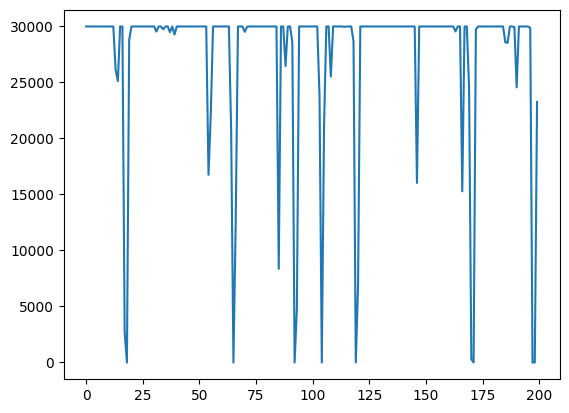

In [57]:
plt.plot(rowcounts[:200])

[(0.1299685686826706+0.32257840037345886j)
 (0.1602546125650406+0.2130133956670761j)
 (0.20384889841079712+0.20947349071502686j)
 (0.21572108566761017+0.1414606273174286j)
 (0.25253376364707947+0.11324449628591537j)
 (0.3410645127296448+0.0869944617152214j)
 (0.3936717212200165+0.03727645426988602j)
 (0.33797407150268555-0.038010671734809875j)
 (0.2758904993534088-0.09682632982730865j)
 (0.270289808511734-0.13174593448638916j)
 (0.21634510159492493-0.151488795876503j)
 (0.1941116452217102-0.22084711492061615j)
 (0.21561580896377563-0.33591198921203613j)
 (0.1516379714012146-0.31760406494140625j)
 (0.0926380604505539-0.3144707977771759j)
 (0.06282132118940353-0.3180341124534607j)
 (0.018116090446710587-0.22244492173194885j)
 (0.09891436994075775-0.3211466670036316j) --
 (-0.12143193185329437-0.30206847190856934j)
 (-0.15399253368377686-0.26541152596473694j)
 (-0.16276083886623383-0.2153046429157257j)
 (-0.1739274114370346-0.18957093358039856j)
 (-0.2416246086359024-0.15451575815677643j)

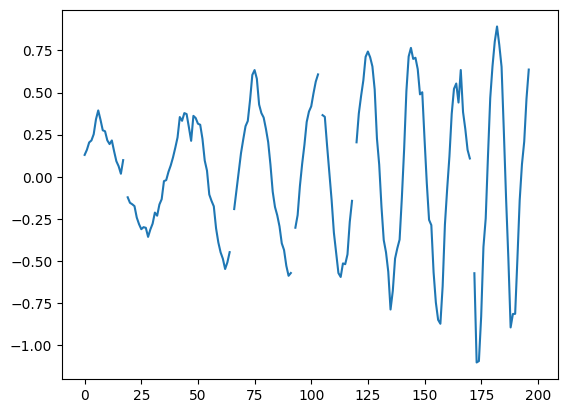

In [66]:
chan0 = pols[0][:200,2]
print(chan0)
plt.plot(np.real(chan0))


In [59]:
angles = np.angle(pols[0])

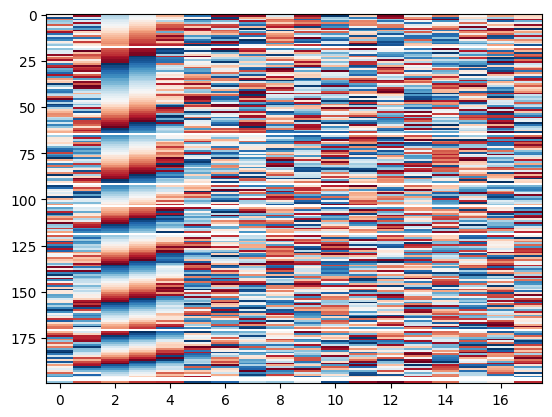

In [60]:
plt.imshow(angles[:200,:], aspect='auto',cmap='RdBu',interpolation="none")

In [23]:
obs = np.unwrap(angles[:, 3])
obs.shape
print(obs)


[ 3.54782045e-01  5.38562164e-02 -1.86385810e-01 -5.26532054e-01
 -8.19050670e-01 -1.16767514e+00 -1.45973885e+00 -1.71324039e+00
 -1.97862852e+00 -2.16797781e+00 -2.36179996e+00 -2.68870592e+00
 -2.82190537e+00 -3.03011560e+00 -3.37708473e+00 -3.59139967e+00
 -3.87213087e+00 -4.16958761e+00 -4.48115492e+00 -4.73673582e+00
 -5.04996634e+00 -5.26691628e+00 -5.51144934e+00 -5.74671936e+00
 -6.03991175e+00 -6.33547449e+00 -6.52868176e+00 -6.84146357e+00
 -7.14597178e+00 -7.43468285e+00 -7.70876646e+00 -8.04379845e+00
 -8.48384857e+00 -8.79121113e+00 -9.12622833e+00 -9.48735905e+00
 -9.89683437e+00 -1.02877245e+01 -1.06655083e+01 -1.13009663e+01
 -1.14933043e+01 -1.18547192e+01 -1.22528496e+01 -1.26241732e+01
 -1.29424534e+01 -1.32511683e+01 -1.36069908e+01 -1.40047588e+01
 -1.43106642e+01 -1.47172842e+01 -1.51357212e+01 -1.55449524e+01
 -1.58105812e+01 -1.61875248e+01 -1.65787792e+01 -1.68064556e+01
 -1.75998802e+01 -1.79565105e+01 -1.83733177e+01 -1.87802029e+01
 -1.92488594e+01 -1.96765

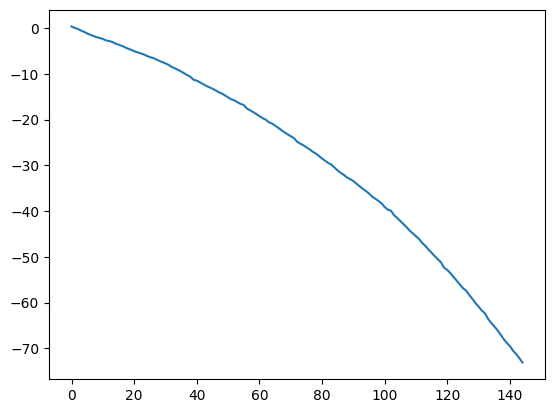

In [24]:
plt.plot(obs)